Loading datasets...
Positive samples: 3686
Negative samples (total): 2884741
Negative samples (sampled): 3686

 Processing Model: all-mpnet-base-v2
Loading Model (all-mpnet-base-v2)...
Encoding sentences...
Computing Cosine Similarities...
Starting 5-Fold Cross Validation...

--- Results per Threshold (all-mpnet-base-v2) ---
Threshold  | F1 (Mean)  | F1 (Var)   | Prec (Mean) | Rec (Mean) | PosAcc     | NegAcc    
------------------------------------------------------------------------------------------
0.10       | 0.7340     | 0.0002     | 0.5809     | 0.9975     | 0.9975     | 0.2803
0.11       | 0.7437     | 0.0003     | 0.5934     | 0.9964     | 0.9964     | 0.3177
0.12       | 0.7547     | 0.0003     | 0.6082     | 0.9948     | 0.9948     | 0.3595
0.13       | 0.7676     | 0.0002     | 0.6257     | 0.9931     | 0.9931     | 0.4061
0.14       | 0.7804     | 0.0002     | 0.6432     | 0.9926     | 0.9926     | 0.4495
0.15       | 0.7932     | 0.0001     | 0.6614     | 0.9910     | 0.

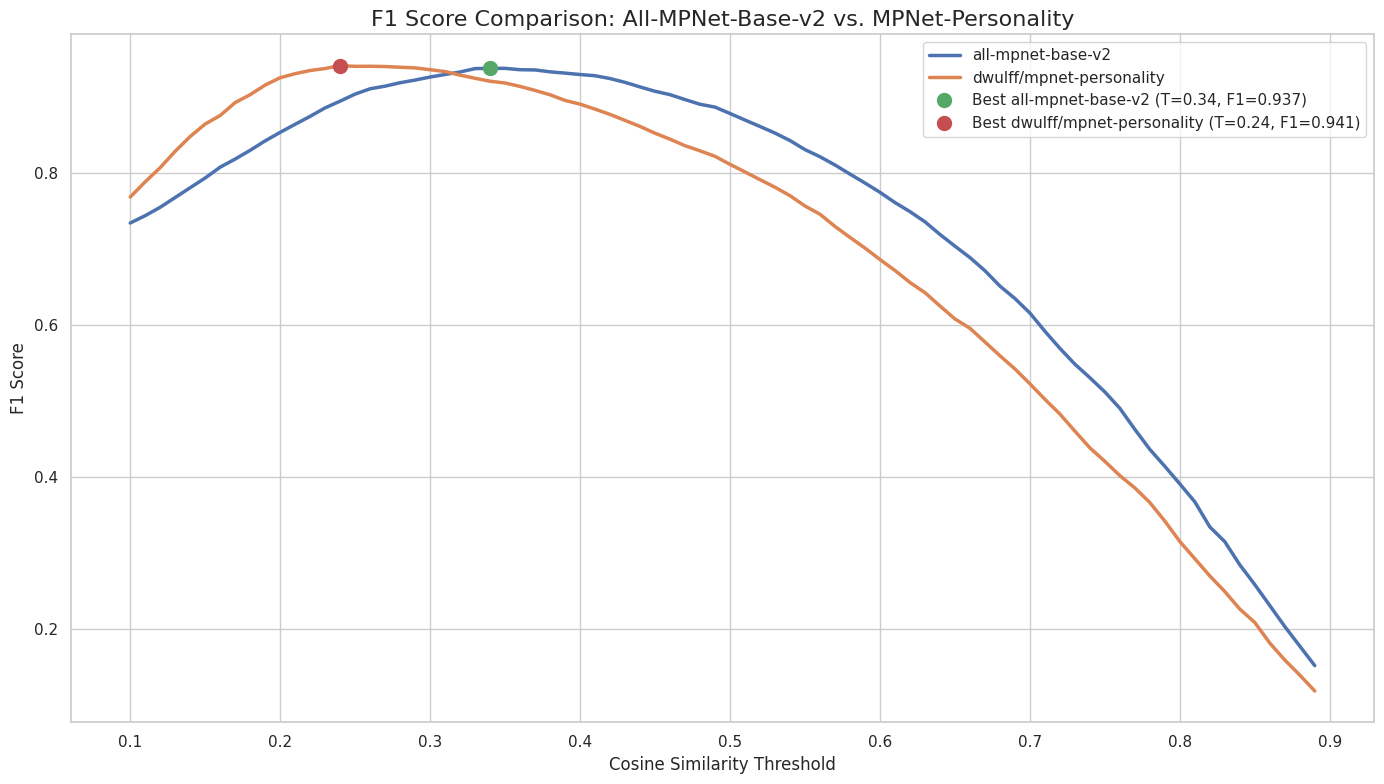

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Reproducibility Setup
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# 1. Load Data
print("Loading datasets...")
try:
    pos_df = pd.read_csv('datasets/processed_datasets/train_positive_pairs.csv', on_bad_lines='skip')
    neg_df = pd.read_csv('datasets/processed_datasets/train_negative_pairs.csv', on_bad_lines='skip')
except Exception as e:
    print(f"Error loading files: {e}")
    exit()

# 2. Random Sampling
print(f"Positive samples: {len(pos_df)}")
print(f"Negative samples (total): {len(neg_df)}")

n_pos = len(pos_df)
if len(neg_df) > n_pos:
    neg_df_sampled = neg_df.sample(n=n_pos, random_state=SEED)
else:
    neg_df_sampled = neg_df
print(f"Negative samples (sampled): {len(neg_df_sampled)}")

# Combine and cleaning
df = pd.concat([pos_df, neg_df_sampled])
# Shuffle entire dataset
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

df['term1'] = df['term1'].astype(str)
df['term2'] = df['term2'].astype(str)
labels = df['label'].values

# Models to evaluate
models_to_test = ['all-mpnet-base-v2', 'dwulff/mpnet-personality']
all_summary_data = []

for model_name in models_to_test:
    print(f"\n{'='*40}")
    print(f" Processing Model: {model_name}")
    print(f"{'='*40}")

    # 3. Model & Encoding
    print(f"Loading Model ({model_name})...")
    try:
        model = SentenceTransformer(model_name)
    except Exception as e:
        print(f"Failed to load {model_name}: {e}")
        continue

    print("Encoding sentences...")
    embeddings1 = model.encode(df['term1'].tolist(), convert_to_tensor=True, show_progress_bar=False, batch_size=16)
    embeddings2 = model.encode(df['term2'].tolist(), convert_to_tensor=True, show_progress_bar=False, batch_size=16)

    # 4. Compute Cosine Similarities
    print("Computing Cosine Similarities...")
    similarities = torch.nn.functional.cosine_similarity(embeddings1, embeddings2).cpu().numpy()

    # 5. Cross Validation & Threshold Optimization
    print("Starting 5-Fold Cross Validation...")
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    thresholds = np.arange(0.10, 0.90, 0.01)

    fold_metrics = {t: {'precision': [], 'recall': [], 'f1': [], 'pos_acc': [], 'neg_acc': []} for t in thresholds}

    # Execute CV
    for fold, (train_idx, val_idx) in enumerate(kf.split(similarities)):
        # print(f"Processing Fold {fold + 1}/5...")
        val_sims = similarities[val_idx]
        val_labels = labels[val_idx]
        
        for t in thresholds:
            preds = (val_sims > t).astype(int)
            
            # Calculate metrics
            p = precision_score(val_labels, preds, zero_division=0)
            r = recall_score(val_labels, preds, zero_division=0)
            f1 = f1_score(val_labels, preds, zero_division=0)
            
            # Class-specific accuracy
            pos_mask = (val_labels == 1)
            neg_mask = (val_labels == 0)
            
            pos_acc = np.mean(preds[pos_mask] == 1) if np.any(pos_mask) else 0.0
            neg_acc = np.mean(preds[neg_mask] == 0) if np.any(neg_mask) else 0.0

            fold_metrics[t]['precision'].append(p)
            fold_metrics[t]['recall'].append(r)
            fold_metrics[t]['f1'].append(f1)
            fold_metrics[t]['pos_acc'].append(pos_acc)
            fold_metrics[t]['neg_acc'].append(neg_acc)

    # 6. Aggregating
    print(f"\n--- Results per Threshold ({model_name}) ---")
    print(f"{'Threshold':<10} | {'F1 (Mean)':<10} | {'F1 (Var)':<10} | {'Prec (Mean)':<10} | {'Rec (Mean)':<10} | {'PosAcc':<10} | {'NegAcc':<10}")
    print("-" * 90)

    current_model_results = []
    
    # Track best for this model
    best_f1_model = -1
    best_threshold_model = -1
    
    for t in thresholds:
        # Aggregating
        avg_p = np.mean(fold_metrics[t]['precision'])
        var_p = np.var(fold_metrics[t]['precision'])
        
        avg_r = np.mean(fold_metrics[t]['recall'])
        var_r = np.var(fold_metrics[t]['recall'])
        
        avg_f1 = np.mean(fold_metrics[t]['f1'])
        var_f1 = np.var(fold_metrics[t]['f1'])

        avg_pos = np.mean(fold_metrics[t]['pos_acc'])
        avg_neg = np.mean(fold_metrics[t]['neg_acc'])
        
        # Update specific model best
        if avg_f1 > best_f1_model:
            best_f1_model = avg_f1
            best_threshold_model = t
        
        result_entry = {
            'model': model_name,
            'threshold': t,
            'precision_mean': avg_p, 'precision_var': var_p,
            'recall_mean': avg_r, 'recall_var': var_r,
            'f1_mean': avg_f1, 'f1_var': var_f1,
            'pos_acc_mean': avg_pos,
            'neg_acc_mean': avg_neg
        }
        all_summary_data.append(result_entry)
        current_model_results.append(result_entry)
        
        print(f"{t:.2f}       | {avg_f1:.4f}     | {var_f1:.4f}     | {avg_p:.4f}     | {avg_r:.4f}     | {avg_pos:.4f}     | {avg_neg:.4f}")

    # Generate Individual Plot
    print(f"Generating plot for {model_name}...")
    current_df = pd.DataFrame(current_model_results)
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=current_df, x='threshold', y='f1_mean', label='F1 Score', linewidth=2.5)
    sns.lineplot(data=current_df, x='threshold', y='precision_mean', label='Precision', linestyle='--')
    sns.lineplot(data=current_df, x='threshold', y='recall_mean', label='Recall', linestyle='--')
    
    plt.axvline(x=best_threshold_model, color='r', linestyle=':', label=f'Best Threshold ({best_threshold_model:.2f})')
    
    plt.title(f'Model Performance: {model_name}', fontsize=16)
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.legend()
    plt.tight_layout()
    
    safe_name = model_name.replace('/', '_').replace('-', '_')
    plt.savefig(f'performance_graph_{safe_name}.png')
    print(f"Graph saved to 'performance_graph_{safe_name}.png'")
    # Close plot to avoid interference
    plt.close()


# Save results
summary_df = pd.DataFrame(all_summary_data)
summary_df.to_csv('cv_results.csv', index=False)
print(f"\nDetailed results saved to 'cv_results.csv'")

# 7. Plotting
print("Generating plot...")
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 8))

# Plot F1 Score Comparison
sns.lineplot(data=summary_df, x='threshold', y='f1_mean', hue='model', linewidth=2.5)

# Find best points for annotation
for model_name in summary_df['model'].unique():
    model_data = summary_df[summary_df['model'] == model_name]
    if not model_data.empty:
        best_idx = model_data['f1_mean'].idxmax()
        best_row = model_data.loc[best_idx]
        
        plt.plot(best_row['threshold'], best_row['f1_mean'], 'o', markersize=10, 
                 label=f"Best {model_name} (T={best_row['threshold']:.2f}, F1={best_row['f1_mean']:.3f})")

plt.title('F1 Score Comparison: All-MPNet-Base-v2 vs. MPNet-Personality', fontsize=16)
plt.xlabel('Cosine Similarity Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend()
plt.tight_layout()

plt.savefig('performance_comparison.png')
print(f"Graph saved to 'performance_comparison.png'")

# 8. Best Settings Report
print("\n" + "="*40)
print(" BEST SETTINGS PER MODEL ")
print("="*40)
for model_name in summary_df['model'].unique():
    model_data = summary_df[summary_df['model'] == model_name]
    if not model_data.empty:
        best_idx = model_data['f1_mean'].idxmax()
        best_row = model_data.loc[best_idx]
        print(f"Model: {model_name}")
        print(f"  Optimal Threshold: {best_row['threshold']:.2f}")
        print(f"  Max F1 Score:      {best_row['f1_mean']:.4f}")
        print(f"  Precision:         {best_row['precision_mean']:.4f}")
        print(f"  Recall:            {best_row['recall_mean']:.4f}")
        print("-" * 40)
